### Using the Kalman Filter to Dynamically Estimate Hedging Ratio
---

Here we look at applying the Kalman Filter in a linear regression context to estimate the hedging ratio between
two cointegrated series.

In [99]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pykalman import KalmanFilter as KF
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,10



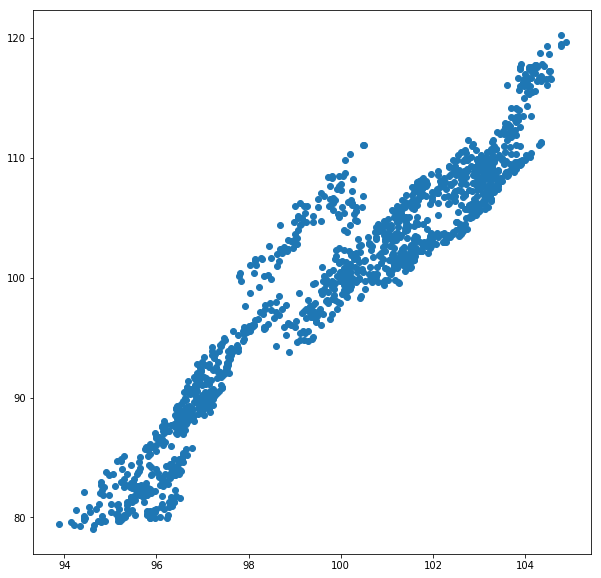

In [111]:
data = pd.read_csv('yields.csv', index_col = 0)

# Sort the data by the index

data.index = pd.to_datetime(data.index)

data = data.sort_index(ascending= True)

data = data[data['3y'] != '--']
data = data.astype(dtype = 'float')

data.columns = ['IEL', 'TFT']

plt.scatter(data['IEL'], data['TFT'])

#plt.plot(data['3y'])
#plt.plot(data['20y'])





In [112]:
etfs = ['IEL', 'TFT']
prices = data

In [113]:
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the
    changing relationship between the sets of prices
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')
    colours = np.linspace(0.1, 1, plen)

    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]],
        s=30, c=colours, cmap=colour_map,
        edgecolor='k', alpha=0.8
    )

    # Add a colour bar for the date colouring and set the
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

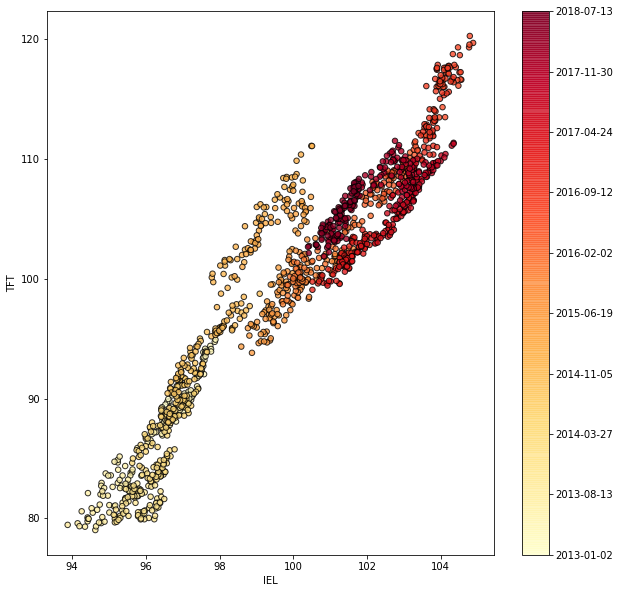

In [114]:
draw_date_coloured_scatterplot(etfs, prices)

In [141]:
# TLT = 20y maturity
# IEI = 3-7y maturity

# Dynamically adjust the intercept and slope between TLT and IEI

# Step 1: Define a variable called *delta* which we used to control the transition covariance matrix
# for the system noise - multiple this term with a 2x2 Identity Matrix 

# Step 2: Create the observation matrix 
    # Row vector consisting of prices of TFT and a sequence of unity values
    # Use the *vstack* numpy method to vertically stack these two vectors into a single vector
        # Take its transpose

# Step 3: Use the Kalman Filter class to create the Kalman Filter Instance
    # Dimensionality of Observations: 1
    # Dimensionality of State: 2 (intercept and slope in LinReg)
    
# Step 4: Supply the mean and covariance of the initial state
    # Set initial state to be zero for both intercept and slope
    # Two-dimensional Identity matrix for the Covariance matrix
    # Transition matrices are also given by 2x2 Identity Matrices
    
# Step 5: Specify the observation matrices
    # Covariance is unity

# Step 6: Transition Covariance Matrix (delta) is given by 

def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-4
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]

    kf = KF(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs



In [139]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0],
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

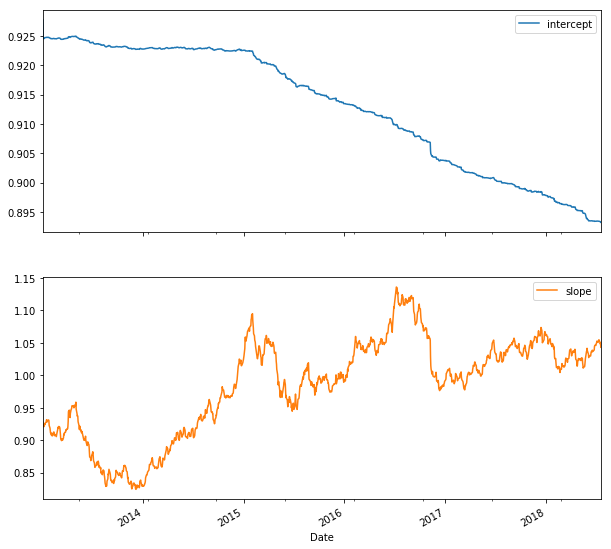

In [142]:
statemeans, statecovs = calc_slope_intercept_kalman(etfs, prices)

draw_slope_intercept_changes(prices,statemeans)